# DQN Dyad Experiments

In [164]:
import gym
import sys, time
import numpy as np; 
from numpy import asarray as narr
import matplotlib.pyplot as plt
from collections import namedtuple
from copy import deepcopy
import torch
from torch import nn, optim
import pickle

In [213]:
# Import custom scripts

sys.path.append('agents/')
sys.path.append('util/')
import env_old
from util import buffers, nn_models, torch_trainer
from agents import rl_agent, train_agents, benchmark_agents

In [218]:
import importlib
importlib.reload(benchmark_agents)

<module 'agents.benchmark_agents' from '/nfs/nfs7/home/sheybani/GitRepos/B659-RL-Project/agents/benchmark_agents.py'>

In [11]:
def benchmark(algo, hp, env, agent1, agent2, xaxis_params):
    # Creates time series for algorithm quality across episodes
    
    dyad_eval = benchmark_agents.dyad_eval
    
    t0 = time.time()
    
    # Unzip arguments
    n_episodes, n_intervals, n_eval = xaxis_params
    int_episodes=int(n_episodes/n_intervals)
    
    x, y = np.zeros(n_intervals+1), np.zeros(n_intervals+1)

    x[0] = 0
    y[0] = dyad_eval(env, agent1, agent2, n_episodes=1, normalizer=True)
    
    # Evaluate the created policy once every int_episodes episodes
    for i in range(n_intervals):
        print('Episode ', i*int_episodes, ': loss= ', y[i])
        
        for j in range(int_episodes):
            agent1, agent2 = algo(env, agent1, agent2)
            if i*int_episodes+j % hp.target_int == 0:
                agent1.update_target_qnet()
            elif i*int_episodes+j % hp.target_int == 4:
                agent2.update_target_qnet()
            
        x[i+1] = (i+1)*int_episodes
        y[i+1] = dyad_eval(env, agent1, agent2, n_episodes=n_eval, normalizer=True)
        
        ct = time.time()
        estimated_time_left = (n_intervals-i)*(ct-t0)/(i+1)
        print('Estimated time left: ', estimated_time_left)
        
    print('Total Duration: ', (ct- t0)/60, ' Minutes')
    return x,y, agent1, agent2
        

/u/sheybani/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode  0 : loss=  -0.23308697091371347
Estimated time left:  121.97449731826782
Episode  5 : loss=  -0.20500305021253473
Estimated time left:  59.81451463699341
Total Duration:  1.993817154566447  Minutes


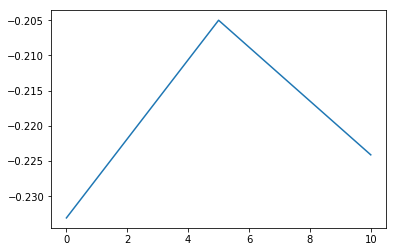

In [6]:
# Main

#------- Training hyperparams
BMHyperparams = namedtuple('BMHyperparams',
                ('batch_size','learning_rate', 'buffer_max_size',
                 'experience_sift_tol', 'target_int'))
#Benchmark x-axis related
n_episodes = 10 #recommended: 100
n_intervals = 2
n_eval = 3

# Buffer-related
experience_sift_tol = 0.01
buffer_max_size = 2000

# Algo hyperparams
learning_rate=0.001
batch_size=128
target_int = 2
xaxis_params = (n_episodes, n_intervals, n_eval)
# initializer = None
hyperparams = BMHyperparams(batch_size, learning_rate, 
                buffer_max_size, experience_sift_tol, target_int)


#------- Create the agents
buffer1 = buffers.ReplayMemory(buffer_max_size, tag=experience_sift_tol)
buffer2 = deepcopy(buffer1)

    #------- Create the NN models
# Input:
# r, r', x, x', fn, fndot, f
# Output: q
qnet = nn_models.NetRelu1L1(7, 1)
optimizer = optim.Adam(qnet.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
rl1 = torch_trainer.DQNTrainer(qnet, optimizer, criterion)
rl2 = deepcopy(rl1)

pdcont1 = [0.1, .2]#[0., 0]#[0.3, 1.]#[0.0364, 1.]#[0.01, 0.03]
pdcont2 = [0.2, 0.1]#[0., 0]#[0.3, 1.]#[0.0364, 1.]#[0.01, 0.03]
sigma = 0. #0.3

agent1 = rl_agent.DQNAgent(rl1, pdcont1, buffer1, perspective=0, sigma=sigma, 
                 hyperparams=hyperparams, c_error=1., c_effort=0.,
                 force_rms=1.)
agent2 = rl_agent.DQNAgent(rl2, pdcont2, buffer2, perspective=1, sigma=sigma, 
                 hyperparams=hyperparams, c_error=1., c_effort=0.,
                 force_rms=1.)
rl1.set_agent(agent1); rl2.set_agent(agent2)


#------- Create the environment
seed = 1234
env = env_old.PhysicalDyads(seed_=seed, max_freq=0.2)
#___________________________________________


agent1.set_train_hyperparams(hyperparams)
agent2.set_train_hyperparams(hyperparams)

algo = train_agents.train_dyad
x_f1, y_f1, agent1_f1, agent2_f1 = benchmark(algo, hyperparams, env, 
                                       agent1, agent2, xaxis_params)

plt.plot(x_f1, y_f1)

In [7]:
agent1, agent2 = agent1_f1, agent2_f1
t_ts, rx_ts, forces_ts, qvals_ts, rewards = benchmark_agents.policy_ts(env, agent1, agent2) 

role1 = narr(qvals_ts[1])-narr(qvals_ts[0]) >0
role2 = narr(qvals_ts[3])-narr(qvals_ts[2]) >0

Env Reward =  -0.22319172169611942  Agent1 Mean Utility =  -0.22300557347118555  Agent2 Mean Utility =  -0.22300557347118555


Text(0.5, 0, 'Time Steps')

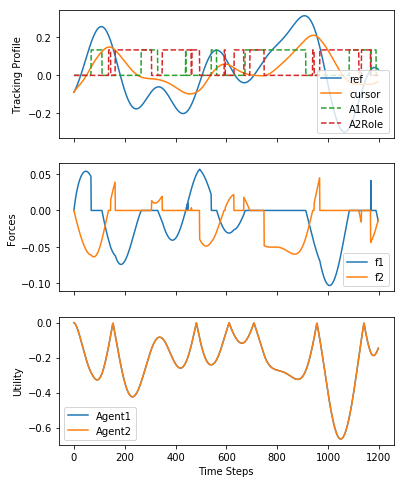

In [31]:
print('Env Reward = ', rewards[2], ' Agent1 Mean Utility = ', rewards[3], ' Agent2 Mean Utility = ', rewards[4])
fig,ax = plt.subplots(3, figsize=(6,8), sharex=True)
ax[0].plot(t_ts, rx_ts[0], label='ref'); 
ax[0].plot(t_ts, rx_ts[1], label='cursor')
ax[0].plot(t_ts, role1*np.mean(abs(narr(rx_ts[0]))),ls='--', label='A1Role');
ax[0].plot(t_ts, role2*np.mean(abs(narr(rx_ts[0]))),ls='--', label='A2Role');
ax[0].set_ylabel('Tracking Profile'); ax[0].legend()
# print('r mean = ', np.mean(abs(env.traj[0])))

ax[1].plot(t_ts, forces_ts[0], label='f1'); 
ax[1].plot(t_ts, forces_ts[1], label='f2'); 
ax[1].set_ylabel('Forces'); ax[1].legend()

ax[2].plot(t_ts, rewards[0], label='Agent1'); ax[2].plot(t_ts, rewards[1], label='Agent2'); 
_=ax[2].set_ylabel('Utility'); ax[2].legend()
ax[-1].set_xlabel('Time Steps')

/u/sheybani/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode  0 : loss=  -0.23308697091371347
Estimated time left:  1247.4493527412415
Episode  10 : loss=  -0.22387048188676337
Estimated time left:  1112.8339655399323
Episode  20 : loss=  -0.3097746744479532
Estimated time left:  986.5463994344076
Episode  30 : loss=  -0.1913897114594488
Estimated time left:  861.9793110489845
Episode  40 : loss=  -0.195796417639484
Estimated time left:  739.6114379882813
Episode  50 : loss=  -0.16503643407180377
Estimated time left:  615.5711646874746
Episode  60 : loss=  -0.44042676079458976
Estimated time left:  493.19047015053883
Episode  70 : loss=  -0.28657127889897976
Estimated time left:  373.17962515354156
Episode  80 : loss=  -0.1819064431897296
Estimated time left:  249.23970985412598
Episode  90 : loss=  -0.4816427995279158
Estimated time left:  124.54999465942383
Total Duration:  20.758332443237304  Minutes


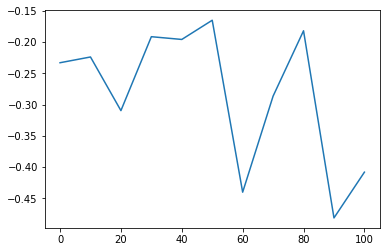

In [5]:
BMHyperparams = namedtuple('BMHyperparams',
                ('batch_size','learning_rate', 'buffer_max_size',
                 'experience_sift_tol', 'target_int'))
#Benchmark x-axis related
n_episodes = 100 #recommended: 100
n_intervals = 10
n_eval = 3

# Buffer-related
experience_sift_tol = 0.01
buffer_max_size = 2000

# Algo hyperparams
learning_rate=0.005
batch_size=128
target_int = 2
xaxis_params = (n_episodes, n_intervals, n_eval)
# initializer = None
hyperparams = BMHyperparams(batch_size, learning_rate, 
                buffer_max_size, experience_sift_tol, target_int)


#------- Create the agents
buffer1 = buffers.ReplayMemory(buffer_max_size, tag=experience_sift_tol)
buffer2 = deepcopy(buffer1)

    #------- Create the NN models
# Input:
# r, r', x, x', fn, fndot, f
# Output: q
qnet = nn_models.NetRelu1L1(7, 1)
optimizer = optim.Adam(qnet.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
rl1 = torch_trainer.DQNTrainer(qnet, optimizer, criterion)
rl2 = deepcopy(rl1)

pdcont1 = [0.1, .2]#[0., 0]#[0.3, 1.]#[0.0364, 1.]#[0.01, 0.03]
pdcont2 = [0.2, 0.1]#[0., 0]#[0.3, 1.]#[0.0364, 1.]#[0.01, 0.03]
sigma = 0. #0.3

agent1 = rl_agent.DQNAgent(rl1, pdcont1, buffer1, perspective=0, sigma=sigma, 
                 hyperparams=hyperparams, c_error=1., c_effort=.5,
                 force_rms=1.)
agent2 = rl_agent.DQNAgent(rl2, pdcont2, buffer2, perspective=1, sigma=sigma, 
                 hyperparams=hyperparams, c_error=1., c_effort=0.5,
                 force_rms=1.)
rl1.set_agent(agent1); rl2.set_agent(agent2)


#------- Create the environment
seed = 1234
env = env_old.PhysicalDyads(seed_=seed, max_freq=0.2)
#___________________________________________


agent1.set_train_hyperparams(hyperparams)
agent2.set_train_hyperparams(hyperparams)

algo = train_agents.train_dyad
x_f2, y_f2, agent1_f2, agent2_f2 = benchmark(algo, hyperparams, env, 
                                       agent1, agent2, xaxis_params)

plt.plot(x_f2, y_f2)

Env Reward =  -0.35260108795126494  Agent1 Mean Utility =  -0.3541509490807234  Agent2 Mean Utility =  -0.35236868869497723


Text(0.5, 0, 'Time Steps')

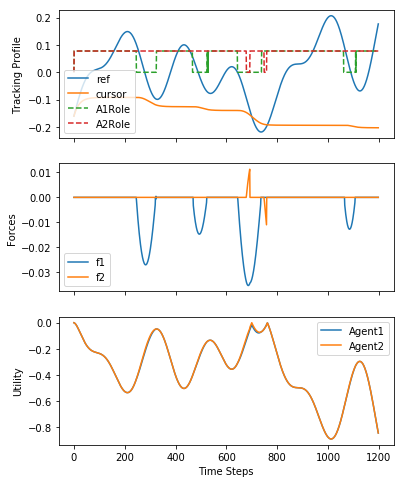

In [6]:
agent1, agent2 = agent1_f2, agent2_f2
t_ts, rx_ts, forces_ts, qvals_ts, rewards = benchmark_agents.policy_ts(env, agent1, agent2) 

role1 = narr(qvals_ts[1])-narr(qvals_ts[0]) >0
role2 = narr(qvals_ts[3])-narr(qvals_ts[2]) >0

print('Env Reward = ', rewards[2], ' Agent1 Mean Utility = ', rewards[3], ' Agent2 Mean Utility = ', rewards[4])
fig,ax = plt.subplots(3, figsize=(6,8), sharex=True)
ax[0].plot(t_ts, rx_ts[0], label='ref'); 
ax[0].plot(t_ts, rx_ts[1], label='cursor')
ax[0].plot(t_ts, role1*np.mean(abs(narr(rx_ts[0]))),ls='--', label='A1Role');
ax[0].plot(t_ts, role2*np.mean(abs(narr(rx_ts[0]))),ls='--', label='A2Role');
ax[0].set_ylabel('Tracking Profile'); ax[0].legend()
# print('r mean = ', np.mean(abs(env.traj[0])))

ax[1].plot(t_ts, forces_ts[0], label='f1'); 
ax[1].plot(t_ts, forces_ts[1], label='f2'); 
ax[1].set_ylabel('Forces'); ax[1].legend()

ax[2].plot(t_ts, rewards[0], label='Agent1'); ax[2].plot(t_ts, rewards[1], label='Agent2'); 
_=ax[2].set_ylabel('Utility'); ax[2].legend()
ax[-1].set_xlabel('Time Steps')

Episode  0 : loss=  -0.2365797730961959
Estimated time left:  1246.7372012138367
Episode  10 : loss=  -0.4475166231836422
Estimated time left:  1122.422014117241
Episode  20 : loss=  -0.18757830576015722
Estimated time left:  995.6786766052246
Episode  30 : loss=  -0.21861955474544256
Estimated time left:  872.086493730545
Episode  40 : loss=  -0.18715110675995872
Estimated time left:  751.6612901687622
Episode  50 : loss=  -0.20319430550427273
Estimated time left:  626.8541791041692
Episode  60 : loss=  -0.19807079745080905
Estimated time left:  503.67546667371477
Episode  70 : loss=  -0.19817980788561698
Estimated time left:  377.2089424431324
Episode  80 : loss=  -0.19591550165086546
Estimated time left:  251.73676930533514
Episode  90 : loss=  -0.21658123735477
Estimated time left:  125.8726776599884
Total Duration:  20.978779609998067  Minutes


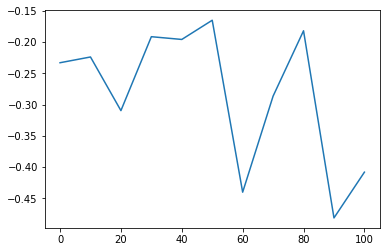

In [9]:
BMHyperparams = namedtuple('BMHyperparams',
                ('batch_size','learning_rate', 'buffer_max_size',
                 'experience_sift_tol', 'target_int'))
#Benchmark x-axis related
n_episodes = 100 #recommended: 100
n_intervals = 10
n_eval = 3

# Buffer-related
experience_sift_tol = 0.01
buffer_max_size = 2000

# Algo hyperparams
learning_rate=0.005
batch_size=128
target_int = 8
xaxis_params = (n_episodes, n_intervals, n_eval)
# initializer = None
hyperparams = BMHyperparams(batch_size, learning_rate, 
                buffer_max_size, experience_sift_tol, target_int)


#------- Create the agents
buffer1 = buffers.ReplayMemory(buffer_max_size, tag=experience_sift_tol)
buffer2 = deepcopy(buffer1)

    #------- Create the NN models
# Input:
# r, r', x, x', fn, fndot, f
# Output: q
qnet = nn_models.NetRelu1L1(7, 1)
optimizer = optim.Adam(qnet.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
rl1 = torch_trainer.DQNTrainer(qnet, optimizer, criterion)
rl2 = deepcopy(rl1)

pdcont1 = [0.1, .2]#[0., 0]#[0.3, 1.]#[0.0364, 1.]#[0.01, 0.03]
pdcont2 = [0.2, 0.1]#[0., 0]#[0.3, 1.]#[0.0364, 1.]#[0.01, 0.03]
sigma = 0. #0.3

agent1 = rl_agent.DQNAgent(rl1, pdcont1, buffer1, perspective=0, sigma=sigma, 
                 hyperparams=hyperparams, c_error=1., c_effort=0.,
                 force_rms=1.)
agent2 = rl_agent.DQNAgent(rl2, pdcont2, buffer2, perspective=1, sigma=sigma, 
                 hyperparams=hyperparams, c_error=1., c_effort=0.,
                 force_rms=1.)
rl1.set_agent(agent1); rl2.set_agent(agent2)


#------- Create the environment
seed = 1234
env = env_old.PhysicalDyads(seed_=seed, max_freq=0.2)
#___________________________________________


agent1.set_train_hyperparams(hyperparams)
agent2.set_train_hyperparams(hyperparams)

algo = train_agents.train_dyad
x_f3, y_f3, agent1_f3, agent2_f3 = benchmark(algo, hyperparams, env, 
                                       agent1, agent2, xaxis_params)

plt.plot(x_f2, y_f2)

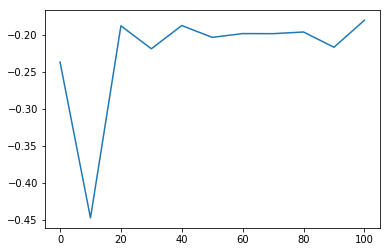

In [10]:
plt.plot(x_f3, y_f3)

Env Reward =  -0.23776339598322874  Agent1 Mean Utility =  -0.23756509456873026  Agent2 Mean Utility =  -0.23756509456873026


Text(0.5, 0, 'Time Steps')

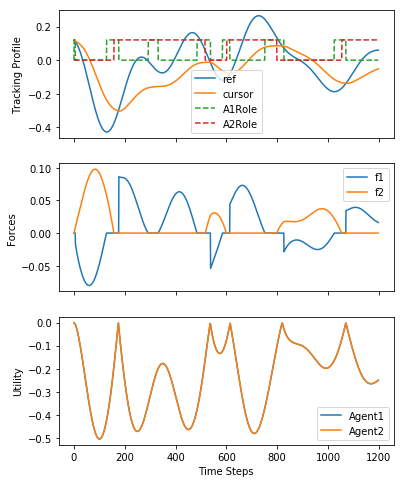

In [12]:
agent1, agent2 = agent1_f3, agent2_f3
t_ts, rx_ts, forces_ts, qvals_ts, rewards = benchmark_agents.policy_ts(env, agent1, agent2) 

role1 = narr(qvals_ts[1])-narr(qvals_ts[0]) >0
role2 = narr(qvals_ts[3])-narr(qvals_ts[2]) >0

print('Env Reward = ', rewards[2], ' Agent1 Mean Utility = ', rewards[3], ' Agent2 Mean Utility = ', rewards[4])
fig,ax = plt.subplots(3, figsize=(6,8), sharex=True)
ax[0].plot(t_ts, rx_ts[0], label='ref'); 
ax[0].plot(t_ts, rx_ts[1], label='cursor')
ax[0].plot(t_ts, role1*np.mean(abs(narr(rx_ts[0]))),ls='--', label='A1Role');
ax[0].plot(t_ts, role2*np.mean(abs(narr(rx_ts[0]))),ls='--', label='A2Role');
ax[0].set_ylabel('Tracking Profile'); ax[0].legend()
# print('r mean = ', np.mean(abs(env.traj[0])))

ax[1].plot(t_ts, forces_ts[0], label='f1'); 
ax[1].plot(t_ts, forces_ts[1], label='f2'); 
ax[1].set_ylabel('Forces'); ax[1].legend()

ax[2].plot(t_ts, rewards[0], label='Agent1'); ax[2].plot(t_ts, rewards[1], label='Agent2'); 
_=ax[2].set_ylabel('Utility'); ax[2].legend()
ax[-1].set_xlabel('Time Steps')

Episode  0 : loss=  -0.23287425902890238
Estimated time left:  1283.0854177474976
Episode  10 : loss=  -0.3695075186226419
Estimated time left:  1144.8007535934448
Episode  20 : loss=  -0.41218783553447597
Estimated time left:  1019.5940920511881
Episode  30 : loss=  -0.2616488077000241
Estimated time left:  887.2551761865616
Episode  40 : loss=  -0.3725201557367013
Estimated time left:  770.9993851661682
Episode  50 : loss=  -0.22610870887446013
Estimated time left:  641.7950026194254
Episode  60 : loss=  -0.2381519301329762
Estimated time left:  513.4641880307879
Episode  70 : loss=  -0.4639999129072894
Estimated time left:  385.50789284706116
Episode  80 : loss=  -0.25476456991989027
Estimated time left:  256.713257683648
Episode  90 : loss=  -0.4209371514498253
Estimated time left:  128.2030918598175
Total Duration:  21.36718197663625  Minutes


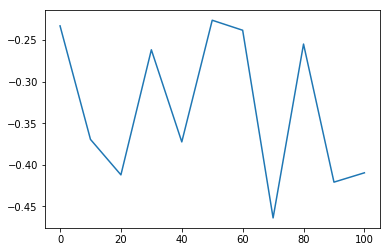

In [15]:
BMHyperparams = namedtuple('BMHyperparams',
                ('batch_size','learning_rate', 'buffer_max_size',
                 'experience_sift_tol', 'target_int'))
#Benchmark x-axis related
n_episodes = 100 #recommended: 100
n_intervals = 10
n_eval = 3

# Buffer-related
experience_sift_tol = 0.01
buffer_max_size = 2000

# Algo hyperparams
learning_rate=0.005
batch_size=128
target_int = 8
xaxis_params = (n_episodes, n_intervals, n_eval)
# initializer = None
hyperparams = BMHyperparams(batch_size, learning_rate, 
                buffer_max_size, experience_sift_tol, target_int)


#------- Create the agents
buffer1 = buffers.ReplayMemory(buffer_max_size, tag=experience_sift_tol)
buffer2 = deepcopy(buffer1)

    #------- Create the NN models
# Input:
# r, r', x, x', fn, fndot, f
# Output: q
qnet = nn_models.NetRelu1L1(7, 1)
optimizer = optim.Adam(qnet.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
rl1 = torch_trainer.DQNTrainer(qnet, optimizer, criterion)
rl2 = deepcopy(rl1)

pdcont1 = [0.1, .2]#[0., 0]#[0.3, 1.]#[0.0364, 1.]#[0.01, 0.03]
pdcont2 = [0.2, 0.1]#[0., 0]#[0.3, 1.]#[0.0364, 1.]#[0.01, 0.03]
sigma = 0. #0.3

agent1 = rl_agent.DQNAgent(rl1, pdcont1, buffer1, perspective=0, sigma=sigma, 
                 hyperparams=hyperparams, c_error=1., c_effort=4.,
                 force_rms=1.)
agent2 = rl_agent.DQNAgent(rl2, pdcont2, buffer2, perspective=1, sigma=sigma, 
                 hyperparams=hyperparams, c_error=1., c_effort=4.,
                 force_rms=1.)
rl1.set_agent(agent1); rl2.set_agent(agent2)


#------- Create the environment
seed = 1234
env = env_old.PhysicalDyads(seed_=seed, max_freq=0.2)
#___________________________________________


agent1.set_train_hyperparams(hyperparams)
agent2.set_train_hyperparams(hyperparams)

algo = train_agents.train_dyad
x_f4, y_f4, agent1_f4, agent2_f4 = benchmark(algo, hyperparams, env, 
                                       agent1, agent2, xaxis_params)

plt.plot(x_f4, y_f4)

Env Reward =  -0.3337673818590722  Agent1 Mean Utility =  -0.33524291029732634  Agent2 Mean Utility =  -0.37975099730905393


Text(0.5, 0, 'Time Steps')

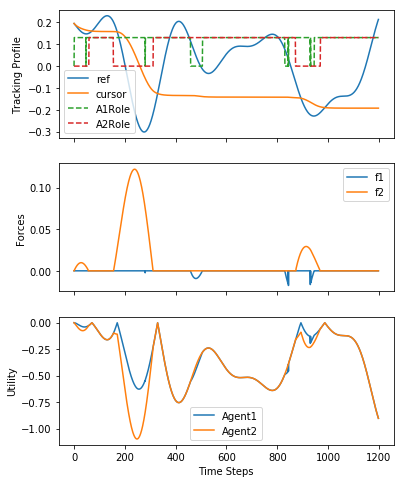

In [17]:
agent1, agent2 = agent1_f4, agent2_f4
t_ts, rx_ts, forces_ts, qvals_ts, rewards = benchmark_agents.policy_ts(env, agent1, agent2) 

role1 = narr(qvals_ts[1])-narr(qvals_ts[0]) >0
role2 = narr(qvals_ts[3])-narr(qvals_ts[2]) >0

print('Env Reward = ', rewards[2], ' Agent1 Mean Utility = ', rewards[3], ' Agent2 Mean Utility = ', rewards[4])
fig,ax = plt.subplots(3, figsize=(6,8), sharex=True)
ax[0].plot(t_ts, rx_ts[0], label='ref'); 
ax[0].plot(t_ts, rx_ts[1], label='cursor')
ax[0].plot(t_ts, role1*np.mean(abs(narr(rx_ts[0]))),ls='--', label='A1Role');
ax[0].plot(t_ts, role2*np.mean(abs(narr(rx_ts[0]))),ls='--', label='A2Role');
ax[0].set_ylabel('Tracking Profile'); ax[0].legend()
# print('r mean = ', np.mean(abs(env.traj[0])))

ax[1].plot(t_ts, forces_ts[0], label='f1'); 
ax[1].plot(t_ts, forces_ts[1], label='f2'); 
ax[1].set_ylabel('Forces'); ax[1].legend()

ax[2].plot(t_ts, rewards[0], label='Agent1'); ax[2].plot(t_ts, rewards[1], label='Agent2'); 
_=ax[2].set_ylabel('Utility'); ax[2].legend()
ax[-1].set_xlabel('Time Steps')

Episode  0 : loss=  -0.37687232079361155
Estimated time left:  275.5956554412842
Episode  10 : loss=  -0.23439055543010415
Estimated time left:  133.2917526960373
Total Duration:  4.443058423201243  Minutes


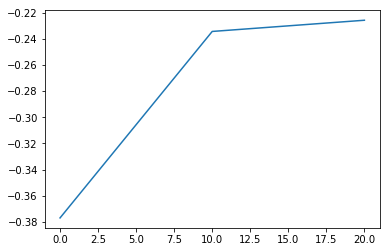

In [175]:
# Pretraining the agents
BMHyperparams = namedtuple('BMHyperparams',
                ('batch_size','learning_rate', 'buffer_max_size',
                 'experience_sift_tol', 'target_int'))
#Benchmark x-axis related
n_episodes = 20 #recommended: 100
n_intervals = 2
n_eval = 3

# Buffer-related
experience_sift_tol = 0.01
buffer_max_size = 1000

# Algo hyperparams
learning_rate=0.005
batch_size=128
target_int = 8
xaxis_params = (n_episodes, n_intervals, n_eval)
# initializer = None
hyperparams = BMHyperparams(batch_size, learning_rate, 
                buffer_max_size, experience_sift_tol, target_int)


#------- Create the agents
buffer1 = buffers.ReplayMemory(buffer_max_size, tag=experience_sift_tol)
buffer2 = deepcopy(buffer1)

    #------- Create the NN models
# Input:
# r, r', x, x', fn, fndot, f
# Output: q
qnet = nn_models.NetRelu1L1(7, 1)
# qnet.load_state_dict(torch.load('data/a1_rl_NetRelu1L1.pth'))
optimizer = optim.Adam(qnet.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
rl1 = torch_trainer.DQNTrainer(qnet, optimizer, criterion)
rl2 = deepcopy(rl1)

pdcont1 = [0.1, .2]#[0., 0]#[0.3, 1.]#[0.0364, 1.]#[0.01, 0.03]
pdcont2 = [0.2, 0.1]#[0., 0]#[0.3, 1.]#[0.0364, 1.]#[0.01, 0.03]
sigma = 0. #0.3

agent1 = rl_agent.DQNAgent(rl1, pdcont1, buffer1, perspective=0, sigma=sigma, 
                 hyperparams=hyperparams, role=1, c_error=1., c_effort=0.,
                 force_rms=1.)
agent2 = rl_agent.DQNAgent(rl2, pdcont2, buffer2, perspective=1, sigma=sigma, 
                 hyperparams=hyperparams, c_error=1., c_effort=0.,
                 force_rms=1.)
rl1.set_agent(agent1); rl2.set_agent(agent2)


#------- Create the environment
seed = 1234
env = env_old.PhysicalDyads(seed_=seed, max_freq=0.2)
#___________________________________________


agent1.set_train_hyperparams(hyperparams)
agent2.set_train_hyperparams(hyperparams)

algo = train_agents.train_dyad
x_fpre, y_fpre, agent1_fpre, agent2_fnone = benchmark(algo, hyperparams, env, 
                                       agent1, agent2, xaxis_params)

plt.plot(x_fpre, y_fpre)

In [176]:
# torch.save(agent1.rl.net.state_dict(), 'data/a1_rl_NetRelu1L1.pth') 
# torch.save(agent2.rl.net.state_dict(), 'data/a2_rl_NetRelu1L1.pth') 

Episode  0 : loss=  -0.22596451214204447
Estimated time left:  1336.4229917526245
Episode  10 : loss=  -0.36429831718947664
Estimated time left:  1202.4369621276855
Episode  20 : loss=  -0.2909888300497645
Estimated time left:  1076.0408325195312
Episode  30 : loss=  -0.1648724762697144
Estimated time left:  938.1866735816002
Episode  40 : loss=  -0.1814568698171007
Estimated time left:  802.7689933776855
Episode  50 : loss=  -0.13276619253371236
Estimated time left:  668.3568690220515
Episode  60 : loss=  -0.15351885589019132
Estimated time left:  535.1433477401733
Episode  70 : loss=  -0.18218649891808547
Estimated time left:  404.1358971297741
Episode  80 : loss=  -0.15241524378194504
Estimated time left:  269.0106886757745
Episode  90 : loss=  -0.17054352337050108
Estimated time left:  134.63316788673401
Total Duration:  22.438861314455668  Minutes


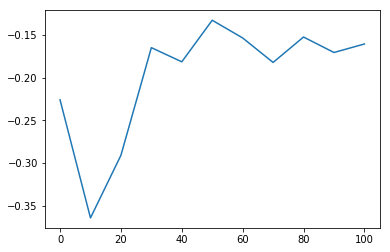

In [177]:
# Run the pretrained agents
BMHyperparams = namedtuple('BMHyperparams',
                ('batch_size','learning_rate', 'buffer_max_size',
                 'experience_sift_tol', 'target_int'))
#Benchmark x-axis related
n_episodes = 100 #recommended: 100
n_intervals = 10
n_eval = 3

# Buffer-related
experience_sift_tol = 0.01
buffer_max_size = 500

# Algo hyperparams
learning_rate=0.005
batch_size=128
target_int = 8
xaxis_params = (n_episodes, n_intervals, n_eval)
# initializer = None
hyperparams = BMHyperparams(batch_size, learning_rate, 
                buffer_max_size, experience_sift_tol, target_int)


#------- Create the agents
buffer1 = buffers.ReplayMemory(buffer_max_size, tag=experience_sift_tol)
buffer2 = deepcopy(buffer1)

    #------- Create the NN models
# Input:
# r, r', x, x', fn, fndot, f
# Output: q
qnet = nn_models.NetRelu1L1(7, 1)
optimizer = optim.Adam(qnet.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
rl1 = torch_trainer.DQNTrainer(qnet, optimizer, criterion)
rl2 = deepcopy(rl1)
# Load pretrained models
rl1.net.load_state_dict(torch.load('data/a1_rl_NetRelu1L1.pth'))
rl2.net.load_state_dict(torch.load('data/a2_rl_NetRelu1L1.pth'))


pdcont1 = [0.1, .2]#[0., 0]#[0.3, 1.]#[0.0364, 1.]#[0.01, 0.03]
pdcont2 = [0.2, 0.1]#[0., 0]#[0.3, 1.]#[0.0364, 1.]#[0.01, 0.03]
sigma = 0. #0.3

agent1 = rl_agent.DQNAgent(rl1, pdcont1, buffer1, perspective=0, sigma=sigma, 
                 hyperparams=hyperparams, c_error=1., c_effort=0.,
                 force_rms=1.)
agent2 = rl_agent.DQNAgent(rl2, pdcont2, buffer2, perspective=1, sigma=sigma, 
                 hyperparams=hyperparams, c_error=1., c_effort=0.,
                 force_rms=1.)
rl1.set_agent(agent1); rl2.set_agent(agent2)


#------- Create the environment
seed = 1234
env = env_old.PhysicalDyads(seed_=seed, max_freq=0.2)
#___________________________________________


agent1.set_train_hyperparams(hyperparams)
agent2.set_train_hyperparams(hyperparams)

algo = train_agents.train_dyad
x_fp1, y_fp1, agent1_fp1, agent2_fp1 = benchmark(algo, hyperparams, env, 
                                       agent1, agent2, xaxis_params)

plt.plot(x_fp1, y_fp1)

In [179]:
pickle.dump((x_fp1, y_fp1, agent1_fp1, agent2_fp1), open( "data/exp10results.p", "wb" ) )

/u/sheybani/.local/lib/python3.6/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [180]:
x_fp11, y_fp11, agent1_fp11, agent2_fp11 = pickle.load( open( "data/exp10results.p", "rb" ) )

In [182]:
agent1_fp1

Episode  0 : loss=  -0.22596451214204447
Estimated time left:  703.0847322940826
Episode  10 : loss=  -0.40639523738949646
Estimated time left:  564.5737223625183
Episode  20 : loss=  -0.20050256045212866
Estimated time left:  422.6778988838196
Episode  30 : loss=  -0.3681558140060079
Estimated time left:  281.7946410179138
Episode  40 : loss=  -0.37188394549877624
Estimated time left:  140.92015447616578
Total Duration:  11.743346206347148  Minutes


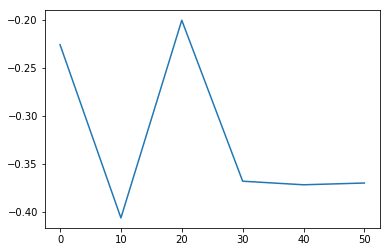

In [219]:
# Run the pretrained agents
BMHyperparams = namedtuple('BMHyperparams',
                ('batch_size','learning_rate', 'buffer_max_size',
                 'experience_sift_tol', 'target_int'))
#Benchmark x-axis related
n_episodes = 50 #recommended: 100
n_intervals = 5
n_eval = 10

# Buffer-related
experience_sift_tol = 0.01
buffer_max_size = 500

# Algo hyperparams
learning_rate=0.005
batch_size=128
target_int = 4
xaxis_params = (n_episodes, n_intervals, n_eval)
# initializer = None
hyperparams = BMHyperparams(batch_size, learning_rate, 
                buffer_max_size, experience_sift_tol, target_int)


#------- Create the agents
buffer1 = buffers.ReplayMemory(buffer_max_size, tag=experience_sift_tol)
buffer2 = deepcopy(buffer1)

    #------- Create the NN models
# Input:
# r, r', x, x', fn, fndot, f
# Output: q
qnet = nn_models.NetRelu1L1(7, 1)
optimizer = optim.Adam(qnet.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
rl1 = torch_trainer.DQNTrainer(qnet, optimizer, criterion)
rl2 = deepcopy(rl1)
# Load pretrained models
rl1.net.load_state_dict(torch.load('data/a1_rl_NetRelu1L1.pth'))
rl2.net.load_state_dict(torch.load('data/a2_rl_NetRelu1L1.pth'))


pdcont1 = [0.1, .2]#[0., 0]#[0.3, 1.]#[0.0364, 1.]#[0.01, 0.03]
pdcont2 = [0.2, 0.1]#[0., 0]#[0.3, 1.]#[0.0364, 1.]#[0.01, 0.03]
sigma = 0. #0.3

agent1 = rl_agent.DQNAgent(rl1, pdcont1, buffer1, perspective=0, sigma=sigma, 
                 hyperparams=hyperparams, c_error=1., c_effort=.5,
                 force_rms=1.)
agent2 = rl_agent.DQNAgent(rl2, pdcont2, buffer2, perspective=1, sigma=sigma, 
                 hyperparams=hyperparams, c_error=1., c_effort=.5,
                 force_rms=1.)
rl1.set_agent(agent1); rl2.set_agent(agent2)


#------- Create the environment
seed = 1234
env = env_old.PhysicalDyads(seed_=seed, max_freq=0.2)
#___________________________________________


agent1.set_train_hyperparams(hyperparams)
agent2.set_train_hyperparams(hyperparams)

algo = train_agents.train_dyad
x_fp2, y_fp2, agent1_fp2, agent2_fp2 = benchmark_agents.benchmark(algo, hyperparams, env, 
                                       agent1, agent2, xaxis_params)

plt.plot(x_fp2, y_fp2)

Env Reward =  -0.2701823352860503  Agent1 Mean Utility =  -0.2744183537547177  Agent2 Mean Utility =  -0.2701452583570651


Text(0.5, 0, 'Time Steps')

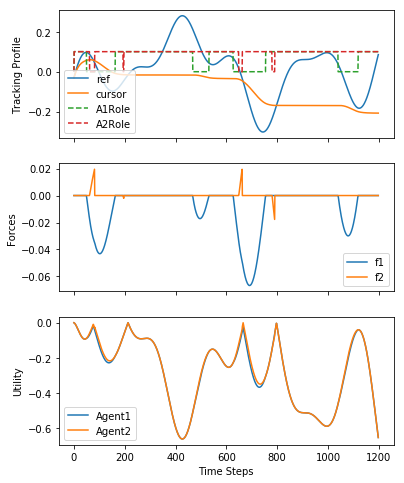

In [221]:
agent1, agent2 = agent1_fp2, agent2_fp2
t_ts, rx_ts, forces_ts, qvals_ts, rewards = benchmark_agents.policy_ts(env, agent1, agent2) 

role1 = narr(qvals_ts[1])-narr(qvals_ts[0]) >0
role2 = narr(qvals_ts[3])-narr(qvals_ts[2]) >0

print('Env Reward = ', rewards[2], ' Agent1 Mean Utility = ', rewards[3], ' Agent2 Mean Utility = ', rewards[4])
fig,ax = plt.subplots(3, figsize=(6,8), sharex=True)
ax[0].plot(t_ts, rx_ts[0], label='ref'); 
ax[0].plot(t_ts, rx_ts[1], label='cursor')
ax[0].plot(t_ts, role1*np.mean(abs(narr(rx_ts[0]))),ls='--', label='A1Role');
ax[0].plot(t_ts, role2*np.mean(abs(narr(rx_ts[0]))),ls='--', label='A2Role');
ax[0].set_ylabel('Tracking Profile'); ax[0].legend()
# print('r mean = ', np.mean(abs(env.traj[0])))

ax[1].plot(t_ts, forces_ts[0], label='f1'); 
ax[1].plot(t_ts, forces_ts[1], label='f2'); 
ax[1].set_ylabel('Forces'); ax[1].legend()

ax[2].plot(t_ts, rewards[0], label='Agent1'); ax[2].plot(t_ts, rewards[1], label='Agent2'); 
_=ax[2].set_ylabel('Utility'); ax[2].legend()
ax[-1].set_xlabel('Time Steps')

In [186]:
np.mean(abs(np.array(forces_ts[1])))

0.025566919883593834

In [149]:
xtt=deque([1,23,5,6], maxlen=5)
for i in range(3):
    xtt.appendleft(i)
xtt+deque([None])

deque([1, 0, 1, 23, None])

In [161]:
xtt=deque([1,23.,5,6], maxlen=1000)
for i in range(1000):
    xtt.appendleft(float(i))
pdist = [np.exp(-3.*t/1000) for t in range(1000)];  pdist[-1]=0.
pdist = np.asarray(pdist)/np.sum(pdist)
t0=time.time()
for i in range(1000):
#     _ = np.random.choice(xtt+deque([None]), size=100, p=pdist, replace=False)
    _ = random.sample(xtt, 100)
print(time.time()-t0)

0.08004498481750488
